In [1]:
!nvidia-smi

Wed Jun 21 10:45:08 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.105.01   Driver Version: 515.105.01   CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100S-PCI...  On   | 00000000:25:00.0 Off |                    0 |
| N/A   62C    P0   237W / 250W |  28566MiB / 32768MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100S-PCI...  On   | 00000000:81:00.0 Off |                    0 |
| N/A   

In [2]:
import argparse
import torch
import torch.nn as nn
from torchvision import transforms as T
from src.dataset.vanilla_lpcvc import LPCVCDataset
import torchvision

from src.model.model import UNET

from tqdm import tqdm
import random
import numpy as np
import cv2

import matplotlib.pyplot as plt

/home/infres/nvernier-22/anaconda3/envs/lpcvc/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
model = UNET(in_channels=3, out_channels=14, features=[64, 128, 256, 512]).to('cuda:1')

In [4]:
t_train = T.Compose([T.ToPILImage(), T.Resize(128)])

train_dataset = LPCVCDataset(datapath='/home/infres/nvernier-22/project/LPCVC-2023/dataset/',transform=t_train, n_class=14, train=True)
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)


In [9]:
img, label = train_dataset[0]

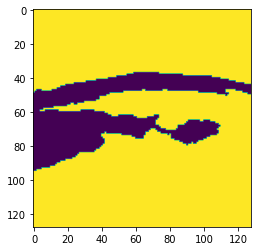

In [11]:
plt.imshow(label[0])

In [12]:
LEARNING_RATE = 1e-4


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scaler = torch.cuda.amp.GradScaler()

In [23]:
def train(model, criterion, optimizer, scaler, train_loader):
    model.train()
    running_loss=0
    loop = tqdm(train_loader)
    
    for batch_idx, (data, targets) in enumerate(loop):
        
        data = data.to(device='cuda:1')
        targets = targets.to(device='cuda:1')        
            
        with torch.cuda.amp.autocast():
            outputs=model(data)
            if(batch_idx == 0):
                output_n = outputs.detach().cpu().numpy()
                target_n = targets.detach().cpu().numpy()
                plt.imsave('/home/infres/nvernier-22/project/LPCVC-2023/src/model/predict'+str(0)+'.png', output_n[0, 0, :, :])
                plt.imsave('/home/infres/nvernier-22/project/LPCVC-2023/src/model/target'+str(0)+'.png', target_n[0, 0, :, :])
            loss = criterion(outputs, targets)
            
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        loop.set_postfix(loss=loss.item())
            
        running_loss += loss.item()

    train_loss=running_loss/len(train_loader)
        
    print('Train Loss: %.3f'%(train_loss))
    return(train_loss)

In [19]:

def draw(i):
    data, target = train_dataset[0]
    data = torch.tensor(data.reshape((1, 3, 128, 128))).to('cuda:1')
    target = torch.tensor(target.reshape((1, 14, 128, 128))).to('cuda:1')
                   
    output=model(data)

    output = output.detach().cpu().numpy()
    target = target.detach().cpu().numpy()

    output = np.argmax(output[0], axis=0)
    plt.imsave('/home/infres/nvernier-22/project/LPCVC-2023/src/model/predict'+str(i)+'.png', output[ :, :])
    if(i==1):
        plt.imsave('/home/infres/nvernier-22/project/LPCVC-2023/src/model/target'+str(i)+'.png', target[0, 0, :, :])

In [24]:
for epoch in range(1, 100):
    print('\nEpoch : %d'%epoch)
    train(model, criterion=criterion, optimizer=optimizer, scaler=scaler, train_loader=train_loader)



Epoch : 1


  0%|          | 0/64 [00:00<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: '/home/infres/nv ernier-22/project/LPCVC-2023/src/model/predict0.png'

In [10]:
torch.save(model.state_dict(), 'src/model/vanilla-lpcvc_'+str(100)+'.pth')

In [ ]:
model.load_state_dict(torch.load("/home/infres/nvernier-22/project/LPCVC-2023/src/model/vanilla-lpcvc_100.pth"))

In [9]:
test_dataset = LPCVCDataset(datapath='/home/infres/nvernier-22/project/LPCVC-2023/dataset/', n_class=14, train=False)
test_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)


  8%|▊         | 5/64 [00:01<00:12,  4.74it/s]


In [ ]:
!nvidia-smi

Tue Jun 20 19:00:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:3B:00.0 Off |                    0 |
| N/A   27C    P0    36W / 250W |  16034MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-PCIE...  On   | 00000000:AF:00.0 Off |                    0 |
| N/A   